# Naive Bayes Network notebook

#### Import dependencies

In [1]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [2]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [3]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [4]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [5]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [6]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['0.Low', '1.Medium', '2.High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name], bins = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True, retbins=True)

        # print(column_name)
        # print(bins[0])
        # print(bins[1])
        # print(bins[2])
        # print(bins[3])

        tert_df[column_name] = tert_df[column_name].cat.rename_categories([ f'Low ({str(round(bins[0]))} to {str(round(bins[1]))}]',
                                                                            f'Medium ({str(round(bins[1]))} to {str(round(bins[2]))}]',
                                                                            f'High ({str(round(bins[2]))} to {str(round(bins[3]))}]'])

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

In [7]:
def discretise(df):
    discrete_df = pd.DataFrame()

    discrete_df['HBW'] = pd.cut(df['HBW'], 2, labels=['1. less than 6 Mbps', '2. greater than 6 Mbps'], ordered=True, retbins=False)
    discrete_df['HTT'] = pd.cut(df['HTT'], 2, labels=['1. less than 178 Milliseconds', '2. greater than 178 Milliseconds'], ordered=True, retbins=False)
    discrete_df['MMIPS'] = pd.cut(df['MMIPS'], 3, labels=['1. less than 750000 MIPS', '2. 750000 to 850000 MIPS', '3. greater than 850000 MIPS'], ordered=True, retbins=False)
    discrete_df['MET'] = pd.cut(df['MET'], 3, labels=['1. less than 1000 Milliseconds', '2. 1000 to 1250 Milliseconds', '3. greater than 1250 Milliseconds'], ordered=True, retbins=False)
    discrete_df['MBW'] = pd.cut(df['MBW'], 3, labels=['1. less than 11 Mbps', '2. 11 to 20 Mbps', '3. greater than 20 Mbps'], ordered=True, retbins=False)
    discrete_df['MTT'] = pd.cut(df['MTT'], 3, labels=['1. less than 18 Milliseconds', '2. 18 to 35 Milliseconds', '3. greater than 35 Milliseconds'], ordered=True, retbins=False)
    discrete_df['RMIPS'] = pd.cut(df['RMIPS'], 3, labels=['1. less than 285000 MIPS', '2. 285000 to 425000 MIPS', '3. greater than 425000 MIPS'], ordered=True, retbins=False)
    discrete_df['RET'] = pd.cut(df['RET'], 2, labels=['1. less than 240 Milliseconds', '2. greater than 240 Milliseconds'], ordered=True, retbins=False)
    discrete_df['RBW'] = pd.cut(df['RBW'], 2, labels=['1. less than 75 Mbps', '2. greater than 75 Mbps'], ordered=True, retbins=False)
    discrete_df['RTT' ] = pd.cut(df['RTT'], 3, labels=['1. less than 90 Milliseconds', '2. 90 to 170 Milliseconds', '3. greater than 170 Milliseconds'], ordered=True, retbins=False)
    discrete_df['BBW'] = pd.cut(df['BBW'], 2, labels=['1. less than 25 Mbps', '2. greater than 25 Mbps'], ordered=True, retbins=False)
    discrete_df['BTT'] = pd.cut(df['BTT'], 2, labels=['1. less than 135 Milliseconds', '2. greater than 135 Milliseconds'], ordered=True, retbins=False)
    discrete_df['TT'] = pd.cut(df['TT'], 3, labels=['1. less than 1625 Milliseconds', '2. 1625 to 2245 Milliseconds', '3. greater than 2245 Millilseconds'], ordered=True, retbins=False)


    

    discrete_df = discrete_df.astype('object')

    return discrete_df

#### Descritise data into catagories

In [8]:
# Discretise BigPerf dataset
cat_df = discretise(df)

cat_df.head(50)

cat_df.to_csv('discretised_bigperf.csv')

In [9]:
discrete_df = discretise(df)

discrete_df.head(1000)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,2. greater than 6 Mbps,1. less than 178 Milliseconds,1. less than 750000 MIPS,1. less than 1000 Milliseconds,3. greater than 20 Mbps,1. less than 18 Milliseconds,2. 285000 to 425000 MIPS,2. greater than 240 Milliseconds,1. less than 75 Mbps,3. greater than 170 Milliseconds,1. less than 25 Mbps,1. less than 135 Milliseconds,1. less than 1625 Milliseconds
1,2. greater than 6 Mbps,1. less than 178 Milliseconds,1. less than 750000 MIPS,1. less than 1000 Milliseconds,3. greater than 20 Mbps,1. less than 18 Milliseconds,1. less than 285000 MIPS,1. less than 240 Milliseconds,1. less than 75 Mbps,1. less than 90 Milliseconds,2. greater than 25 Mbps,1. less than 135 Milliseconds,1. less than 1625 Milliseconds
2,2. greater than 6 Mbps,1. less than 178 Milliseconds,1. less than 750000 MIPS,1. less than 1000 Milliseconds,2. 11 to 20 Mbps,1. less than 18 Milliseconds,2. 285000 to 425000 MIPS,2. greater than 240 Milliseconds,1. less than 75 Mbps,3. greater than 170 Milliseconds,1. less than 25 Mbps,2. greater than 135 Milliseconds,2. 1625 to 2245 Milliseconds
3,2. greater than 6 Mbps,1. less than 178 Milliseconds,1. less than 750000 MIPS,1. less than 1000 Milliseconds,2. 11 to 20 Mbps,1. less than 18 Milliseconds,1. less than 285000 MIPS,1. less than 240 Milliseconds,1. less than 75 Mbps,2. 90 to 170 Milliseconds,1. less than 25 Mbps,2. greater than 135 Milliseconds,1. less than 1625 Milliseconds
4,2. greater than 6 Mbps,1. less than 178 Milliseconds,1. less than 750000 MIPS,1. less than 1000 Milliseconds,2. 11 to 20 Mbps,1. less than 18 Milliseconds,3. greater than 425000 MIPS,2. greater than 240 Milliseconds,1. less than 75 Mbps,2. 90 to 170 Milliseconds,1. less than 25 Mbps,2. greater than 135 Milliseconds,2. 1625 to 2245 Milliseconds
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2. greater than 6 Mbps,1. less than 178 Milliseconds,2. 750000 to 850000 MIPS,2. 1000 to 1250 Milliseconds,3. greater than 20 Mbps,1. less than 18 Milliseconds,2. 285000 to 425000 MIPS,2. greater than 240 Milliseconds,1. less than 75 Mbps,3. greater than 170 Milliseconds,1. less than 25 Mbps,1. less than 135 Milliseconds,2. 1625 to 2245 Milliseconds
996,2. greater than 6 Mbps,1. less than 178 Milliseconds,2. 750000 to 850000 MIPS,2. 1000 to 1250 Milliseconds,2. 11 to 20 Mbps,1. less than 18 Milliseconds,1. less than 285000 MIPS,1. less than 240 Milliseconds,1. less than 75 Mbps,1. less than 90 Milliseconds,2. greater than 25 Mbps,1. less than 135 Milliseconds,1. less than 1625 Milliseconds
997,2. greater than 6 Mbps,1. less than 178 Milliseconds,2. 750000 to 850000 MIPS,2. 1000 to 1250 Milliseconds,1. less than 11 Mbps,3. greater than 35 Milliseconds,2. 285000 to 425000 MIPS,2. greater than 240 Milliseconds,1. less than 75 Mbps,3. greater than 170 Milliseconds,1. less than 25 Mbps,2. greater than 135 Milliseconds,2. 1625 to 2245 Milliseconds
998,2. greater than 6 Mbps,1. less than 178 Milliseconds,2. 750000 to 850000 MIPS,2. 1000 to 1250 Milliseconds,1. less than 11 Mbps,3. greater than 35 Milliseconds,1. less than 285000 MIPS,1. less than 240 Milliseconds,1. less than 75 Mbps,2. 90 to 170 Milliseconds,1. less than 25 Mbps,2. greater than 135 Milliseconds,2. 1625 to 2245 Milliseconds


In [10]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [11]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

In [12]:
model = NaiveBayes(feature_vars=['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT'], dependent_var='TT')

In [13]:
model.fit(data=training_data, parent_node='TT', estimator=MaximumLikelihoodEstimator )
bayes_model = BayesianNetwork(model)

bayes_model.fit(data=training_data,
    estimator=MaximumLikelihoodEstimator,
    complete_samples_only=False)

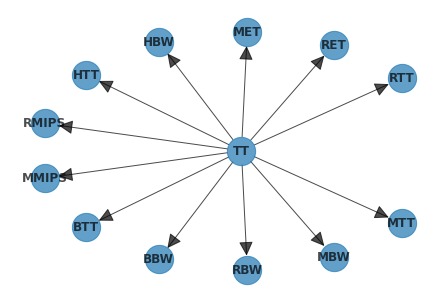

In [14]:
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph

In [15]:
bayes_model.get_cpds()

[<TabularCPD representing P(TT:3) at 0x2289f503a60>,
 <TabularCPD representing P(RTT:3 | TT:3) at 0x2289f5032b0>,
 <TabularCPD representing P(RET:2 | TT:3) at 0x228a11c3160>,
 <TabularCPD representing P(MET:3 | TT:3) at 0x228a11e77c0>,
 <TabularCPD representing P(HBW:2 | TT:3) at 0x228a11c2470>,
 <TabularCPD representing P(HTT:2 | TT:3) at 0x228a12125c0>,
 <TabularCPD representing P(RMIPS:3 | TT:3) at 0x228a11c0d60>,
 <TabularCPD representing P(MMIPS:3 | TT:3) at 0x228a11c3250>,
 <TabularCPD representing P(BTT:2 | TT:3) at 0x228a11e6440>,
 <TabularCPD representing P(BBW:2 | TT:3) at 0x228a11e7c10>,
 <TabularCPD representing P(RBW:2 | TT:3) at 0x228a11c0e50>,
 <TabularCPD representing P(MBW:3 | TT:3) at 0x228a11c1f90>,
 <TabularCPD representing P(MTT:3 | TT:3) at 0x2289f503e50>]

In [16]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=bayes_model, data=testing_data)
ss = structure_score(model=bayes_model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.0
Accuracy score: 0.6153846153846154
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -4584.586127920558
Strcture score: -4704.319040095723


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [18]:
model_name = 'Naive Bayes'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_27280/3521155595.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [19]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of TT:
+----------------------------------------+----------+
| TT(1. less than 1625 Milliseconds)     | 0.165354 |
+----------------------------------------+----------+
| TT(2. 1625 to 2245 Milliseconds)       | 0.553642 |
+----------------------------------------+----------+
| TT(3. greater than 2245 Millilseconds) | 0.281004 |
+----------------------------------------+----------+ 

CPT of RTT:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 

CPT of RET:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 

CPT of MET:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 

CPT of HBW:
+-----------------------------+-----+
| TT                          | ... |
+-----------------------------+-----+
| HBW(1. less than 6 Mbps)    | ... |
+-----------------------------+-----+
| HBW(2. greater than 6 Mbps) | ... |
+-----------------------------+-----+ 

CPT of HTT:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+ 